In [1]:
!pip install matplotlib numpy

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from scipy.ndimage import interpolation as inter
import scipy
import keras_ocr

2023-01-20 13:20:57.795113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 13:20:58.315788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/iduadmin/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-20 13:20:58.315829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/iduadmin/miniconda3/lib/python3.9/site-packages/cv2/.

In [27]:
image = imread("no_shadow.png")

In [28]:
gray_img = rgb2gray(image)
blurred_gray_img = gaussian(gray_img)
print(type(gray_img))

<class 'numpy.ndarray'>


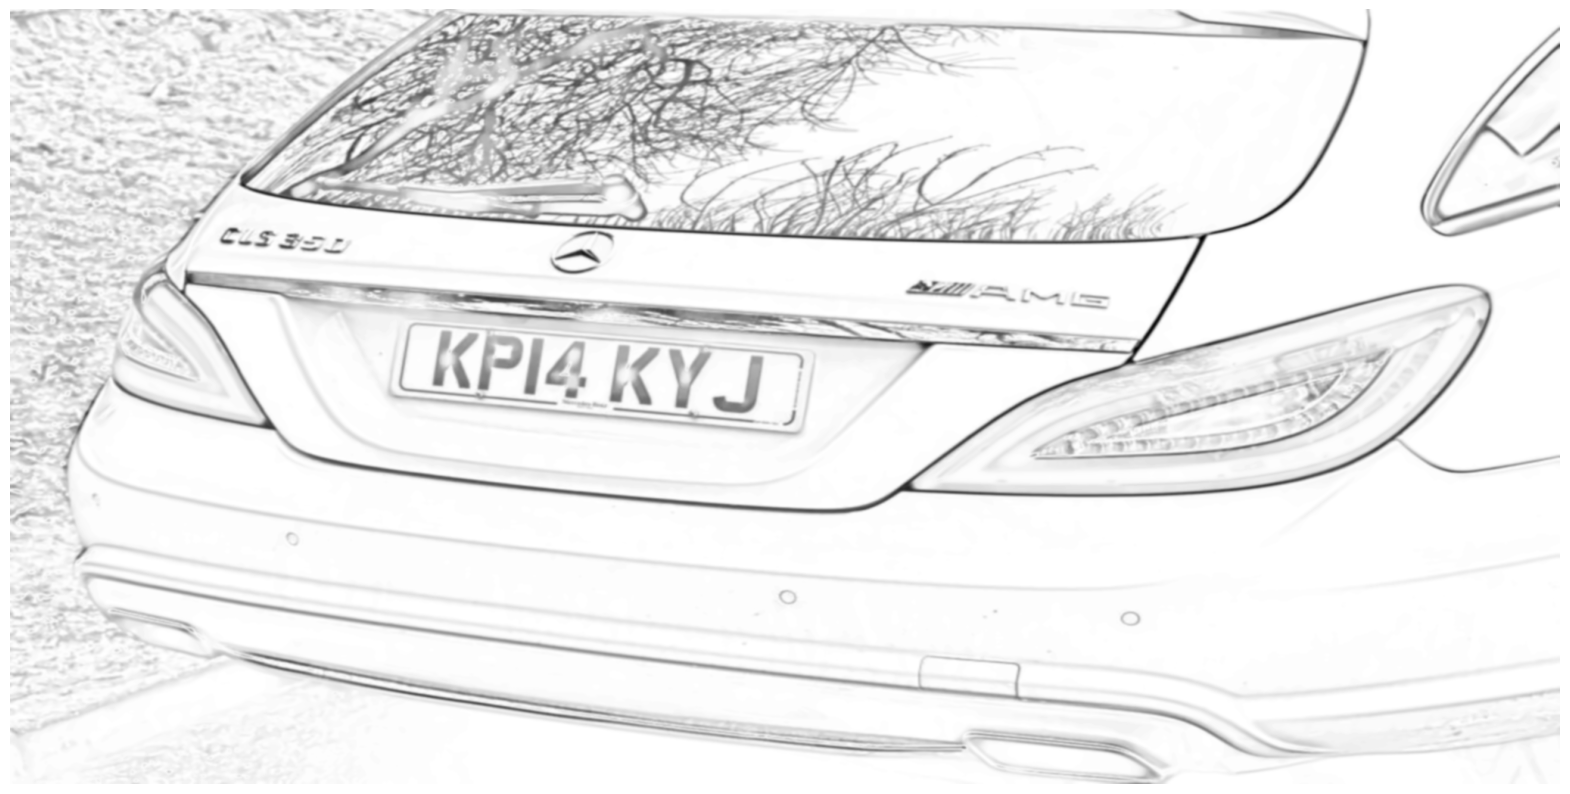

In [29]:
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(blurred_gray_img, cmap="gray")
plt.savefig("bw.png")

0.8213584880514706


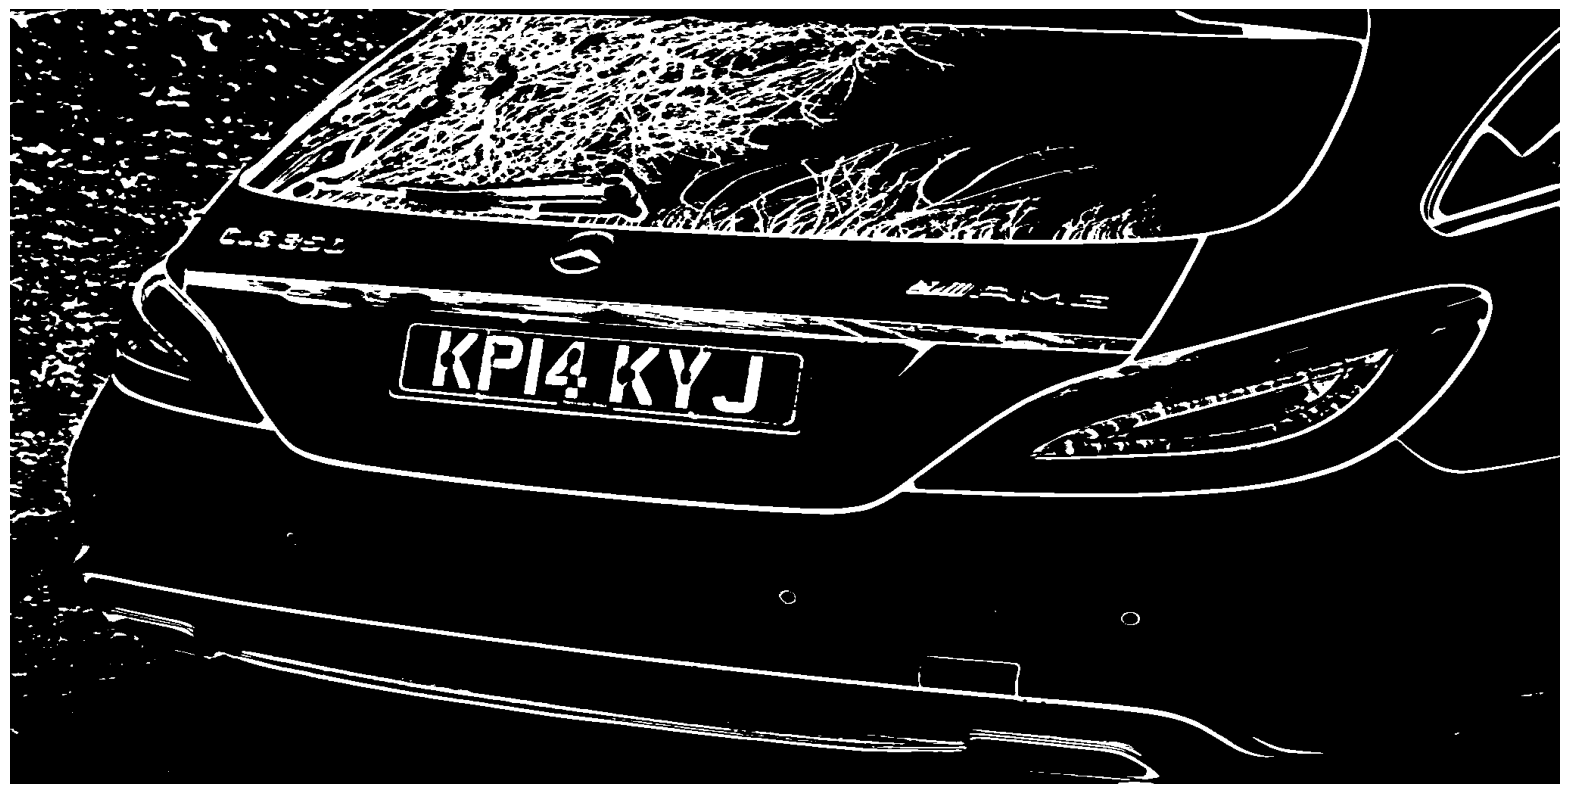

In [30]:
thresh = threshold_otsu(gray_img)
binary = invert(gray_img > thresh)
print(thresh)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(binary, cmap="gray")
plt.savefig("binary.png")

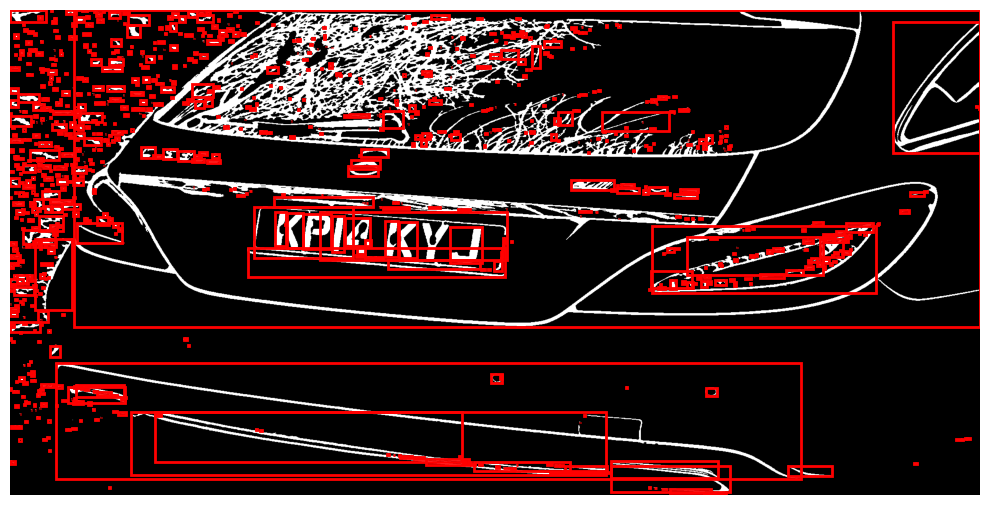

In [31]:
label_image = label(binary, connectivity=2)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(binary, cmap="gray")
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
plt.tight_layout()
plt.show()

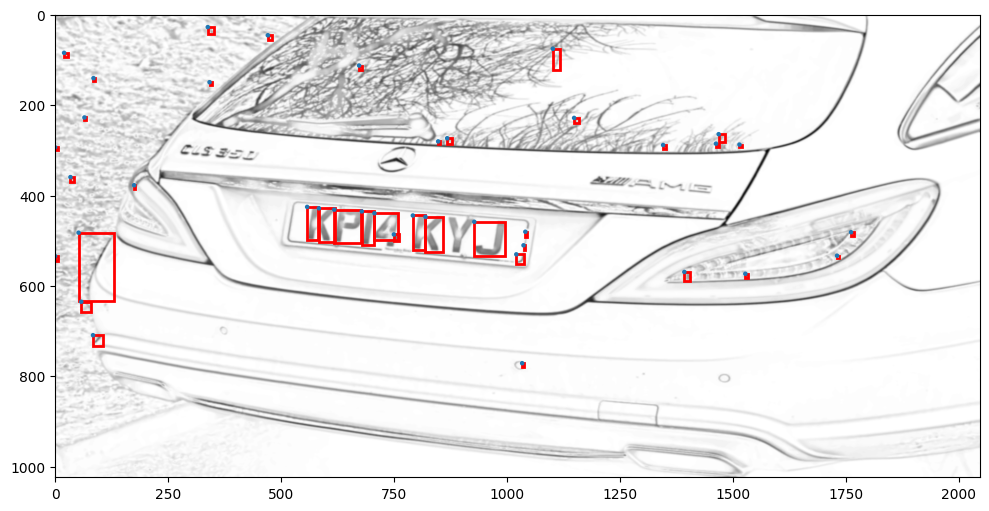

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")

text_like_regions = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    w = maxc - minc
    h = maxr - minr
    
    asr = w/h
    
    region_area = w*h
    
    wid,hei = blurred_gray_img.shape
    img_area = wid*hei
    
    # The aspect ratio is less than 1 to eliminate highly elongated regions
    # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
    # dimension to be considered for further processing
    if region_area > 15 and region_area < (0.009 * img_area) and asr < 1 and h > w:
        #print(w, h, i, region.area, region.bbox)
        text_like_regions.append(region)

all_points = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)
    all_points.append([minc, minr, maxc, maxr])
    
plt.tight_layout()
plt.show()  

/tmp/ipykernel_491068/177030610.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
/tmp/ipykernel_491068/177030610.py:7: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


coordinates of licence plate

[[ 558  425  583  498]
 [ 584  428  619  502]
 [ 618  431  678  504]
 [ 679  435  705  510]
 [ 707  439  759  498]
 [ 792  444  819  520]
 [ 820  447  858  524]
 [ 928  458  995  534]
 [1041  480 1045  492]
 [1037  510 1040  521]
 [1021  530 1039  551]
 [ 928  458  995  534]
 [1041  480 1045  492]
 [1037  510 1040  521]
 [1021  530 1039  551]
 [ 928  458  995  534]
 [1041  480 1045  492]
 [1037  510 1040  521]
 [ 928  458  995  534]
 [1041  480 1045  492]
 [1037  510 1040  521]
 [ 750  486  762  500]]
[[[558, 425], [583, 425], [558, 498], [583, 498]], [[584, 428], [619, 428], [584, 502], [619, 502]], [[618, 431], [678, 431], [618, 504], [678, 504]], [[679, 435], [705, 435], [679, 510], [705, 510]], [[707, 439], [759, 439], [707, 498], [759, 498]], [[792, 444], [819, 444], [792, 520], [819, 520]], [[820, 447], [858, 447], [820, 524], [858, 524]], [[928, 458], [995, 458], [928, 534], [995, 534]], [[1041, 480], [1045, 480], [1041, 492], [1045, 492]], [[1037, 

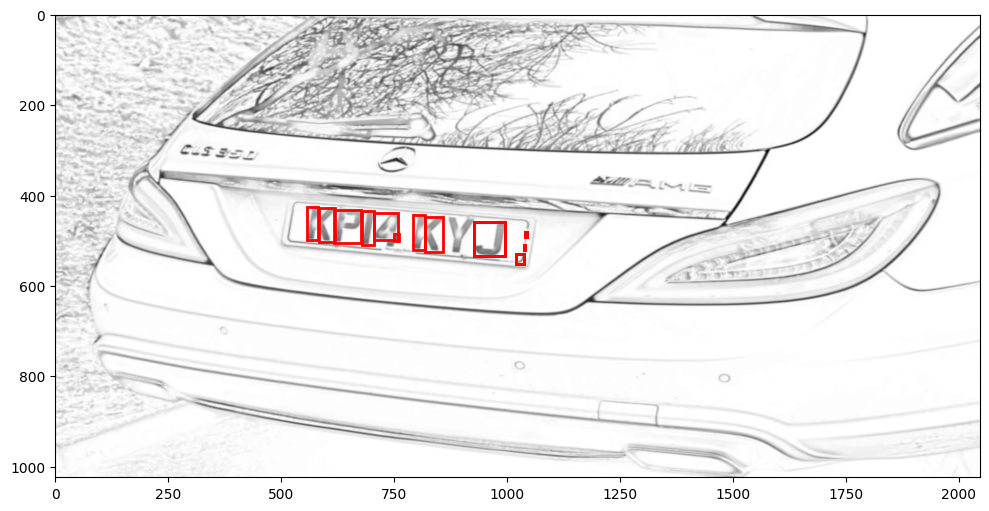

In [33]:
def angle_between_three_points(pointA, pointB, pointC):
    BA = pointA - pointB
    BC = pointC - pointB

    try:
        cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
        angle = np.arccos(cosine_angle)
    except:
        print("exc")
        raise Exception('invalid cosine')

    return np.degrees(angle)

all_points = np.array(all_points)

all_points = all_points[all_points[:,1].argsort()]
height, width = blurred_gray_img.shape
groups = []
for p in all_points:
    cluster = [p]
    lines_found = False
    for q in all_points:
        pmin = np.array([p[0],p[1]])
        qmin = np.array([q[0],q[1]])
        if p[1] < q[1] and euclidean(pmin,qmin) < 0.1 * width:
            # first check if q is already added, if not add.
            point_already_added = False
            for cpoints in cluster:
                if cpoints[0] == q[0] and cpoints[1] == q[1]:
                    point_already_added = True
                    break;
            if not point_already_added:
                cluster.append(q)
                
            for r in all_points:
                rmin = np.array([r[0],r[1]])
                last_cluster_point = np.array([cluster[-1][0],cluster[-1][1]])
                if q[1] < r[0] and euclidean(last_cluster_point,rmin) < 0.1 * width:
                    angle = angle_between_three_points(pmin,qmin,rmin)
                    if angle > 170 and angle < 190:
                        lines_found = True
                        cluster.append(r)
                        
    if lines_found:
        groups.append(np.array(cluster))


# plot the longest found line on the image
longest = -1
longest_index = -1
for index, cluster in enumerate(groups):
    if len(cluster) > longest:
        longest_index = index
        longest = len(cluster)

print("coordinates of licence plate\n")
print(groups[longest_index])

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")
for region in groups[longest_index]:
    minc = region[0]
    minr = region[1] 
    maxc = region[2]
    maxr = region[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
bbox = []
for box in groups[longest_index]:
    
    formatted_box = [[box[0], box[1]], [box[2], box[1]], [box[0], box[3]], [box[2], box[3]]]
    bbox.append(formatted_box)

print(bbox)
plt.tight_layout()
plt.show()

In [171]:
recognize=keras_ocr.recognition.Recognizer()
text = recognize.recognize_from_boxes(images=image, box_groups=bbox)

Looking for /home/iduadmin/.keras-ocr/crnn_kurapan.h5


AssertionError: You must provide the same number of box groups as images.